In [1]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold 
#from sklearn.linear_model import Ridge
#from sklearn.metrics import mean_squared_error
#from sklearn.preprocessing import FunctionTransformer
#from sklearn.model_selection import GridSearchCV
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LassoCV
#from sklearn.datasets import make_regression
from sklearn import svm
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset



import seaborn as sb

#device = 'cpu'

#some code from https://pytorch.org/hub/pytorch_vision_inception_v3/


In [118]:
import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Using cache found in C:\Users\erics/.cache\torch\hub\pytorch_vision_v0.10.0


In [119]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [120]:
newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
newmodel

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, moment

Load data and Preprocess with Resnet 
---

JPEG
(426, 297)
RGB
(297, 426, 3)


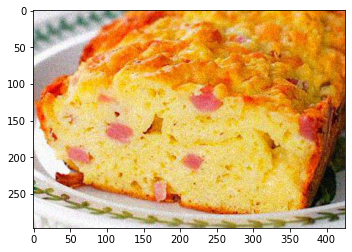

In [2]:
from PIL import Image

img_path = r"C:\Users\erics\Documents\Programme\IntroML\Task3\task3_be9ai3nsdj\food"

image = Image.open(img_path + "/00001.jpg")
print(image.format)
print(image.size)               
print(image.mode)
imageNP = np.asarray(image)
print(imageNP.shape)
plt.imshow(imageNP)
plt.show()

(3, 297, 426)


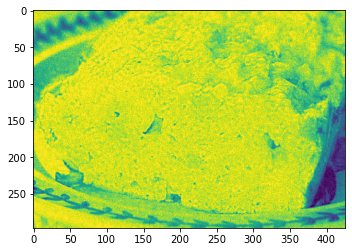

In [9]:
image = []
image.append(imageNP[:,:,0])
image.append(imageNP[:,:,1])
image.append(imageNP[:,:,2])
image = np.asarray(image)
print(image.shape)
plt.imshow(image[0])
plt.show()

In [10]:
import torch.nn.functional as nnf
images = []

for i in range (10000):
    if i < 10:
        add_path = "/0000" + str(i)
    elif i < 100:
        add_path = "/000" + str(i)
    elif i < 1000:
        add_path = "/00" + str(i)
    else:
        add_path = "/0" + str(i)
    imgtmp = np.asarray(Image.open(img_path + add_path + ".jpg"))
    image = []
    image.append(imgtmp[:,:,0])
    image.append(imgtmp[:,:,1])
    image.append(imgtmp[:,:,2])
    imgtmp = np.asarray(image)
    imgtmp = nnf.interpolate(torch.from_numpy(imgtmp)[None,:,:,:], size=(224,224)).numpy()
    images.append(imgtmp[0])
    
imagesArray = np.asarray(images)
    

(3, 224, 224)


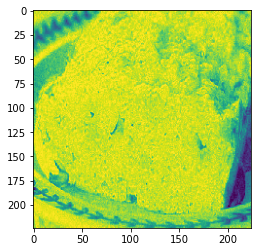

In [11]:
print(imagesArray[0].shape)
plt.imshow(imagesArray[1][0])
plt.show()

In [40]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
input_image = Image.open(img_path + "/00001.jpg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
print(input_batch.size())

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    #output = model(input_batch)
    output = newmodel(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)
output = output.view((1,2048))
print(output.shape)

torch.Size([1, 3, 224, 224])
tensor([[[0.3459]],

        [[0.4165]],

        [[0.1922]],

        ...,

        [[1.2249]],

        [[0.0082]],

        [[0.2500]]], device='cuda:0')
tensor([[[0.0004]],

        [[0.0005]],

        [[0.0004]],

        ...,

        [[0.0010]],

        [[0.0003]],

        [[0.0004]]], device='cuda:0')
torch.Size([1, 2048])


In [10]:
torch.argmax(probabilities)

tensor(963, device='cuda:0')

In [11]:
probabilities[torch.argmax(probabilities)]

tensor(0.8673, device='cuda:0')

In [12]:
indices = torch.topk(probabilities, 5).indices

In [13]:
probabilities[indices]

tensor([0.8673, 0.0694, 0.0184, 0.0155, 0.0041], device='cuda:0')

In [14]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(torch.from_numpy(indices[3]), 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

TypeError: expected np.ndarray (got Tensor)

one could take top 5 but we have not many features therefore we can take a lot more lets take top 50

In [42]:
from PIL import Image
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
indices = []
for i in range(10000):
    if i % 1000 == 0:
        print(i/1000)

    if i < 10:
        add_path = "/0000" + str(i)
    elif i < 100:
        add_path = "/000" + str(i)
    elif i < 1000:
        add_path = "/00" + str(i)
    else:
        add_path = "/0" + str(i)
        
    input_image = Image.open(img_path + add_path + ".jpg")
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        #output = model(input_batch)
        output = newmodel(input_batch)
        output = output.view((1,2048))
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    #probabilities = torch.nn.functional.softmax(output[0], dim=0)
    
    #indices.append(torch.topk(probabilities, 50).indices.numpy())
    #indices.append(probabilities.numpy()) #we need all such that the model can learn to connect the input to a specific thing and use the probability as wheight
    indices.append(output[0])

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [43]:
indices = np.array(indices)
print(indices.shape)

(10000,)


In [44]:
np.save("indicesResnet50_allOutput0", indices)

In [3]:
indices = np.load("indicesResnetInceptionV3_allProba.npy")

In [20]:
indices = indices.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

New model finedtuned on food data but only available in TF :(

In [3]:
images = np.zeros((10000,299,299,3))
    
for i in range(10000):
    if i % 1000 == 0:
        print(i/1000)

    if i < 10:
        add_path = "/0000" + str(i)
    elif i < 100:
        add_path = "/000" + str(i)
    elif i < 1000:
        add_path = "/00" + str(i)
    else:
        add_path = "/0" + str(i)
        
    input_image = np.asarray(Image.open(img_path + add_path + ".jpg").resize((299,299)))
    images[i] = (input_image)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
images.shape

(10000, 299, 299, 3)

In [6]:
features = np.zeros((10000,2048))

In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import tensorflow_hub as hub
#CODE: https://tfhub.dev/google/experts/bit/r50x1/in21k/food/1
module = hub.KerasLayer("https://tfhub.dev/google/experts/bit/r50x1/in21k/food/1")
print("loaded")

for i in range(0, 10000, 10):
    if i % 1000 == 0:
        print(i/1000)
    preprocessed_images = tf.keras.applications.inception_v3.preprocess_input(images[i:i+10]).astype("float32")
    if i == 0:
        print("preprocessed")
    #images = ...  # A batch of images with shape [batch_size, height, width, 3].
    #with tf.device('/CPU:0'): #manchmal geht es mit GPU manchmal nicht :( nerviges TF
    feat = module(preprocessed_images)  # Features with shape [batch_size, 2048].
    features[i:i+10] = feat
    #features[i] = feat

loaded
0.0
preprocessed
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [8]:
features = pd.DataFrame(features)
features.to_csv("IMGfeatures.csv", index=False)

In [11]:
features

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.013014,0.0,4.092678,1.278374,1.185288,0.000000,0.344520,0.095382,0.000000,0.387832,...,2.724133,1.496015,0.320499,2.045701,1.734830,0.090502,0.394875,0.703904,1.103169,0.000000
1,0.006464,0.0,0.307963,2.278183,4.739385,1.665782,1.490711,0.199114,0.000000,4.179108,...,0.126278,0.061741,0.270214,2.041371,0.000000,0.200476,0.501538,0.326713,2.405348,0.000000
2,0.049328,0.0,0.612048,1.883691,7.201009,0.970960,0.514950,1.364251,0.000000,0.094007,...,0.623997,0.873560,0.098264,1.585858,0.214910,1.565191,0.253271,0.898920,0.020549,0.602260
3,0.210743,0.0,0.816810,0.279923,1.951972,0.537723,3.164190,0.032215,0.000000,0.337731,...,0.926916,1.455037,0.136630,0.054198,0.000000,0.255754,0.200617,3.308587,0.400555,0.577193
4,0.062018,0.0,2.272671,0.062051,5.299940,0.686741,2.034157,0.000000,0.009299,0.479350,...,0.475317,8.932517,0.252076,0.539203,0.414950,0.000000,0.580889,0.243655,0.698583,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.112855,0.0,0.222997,3.375993,0.636942,3.843160,0.110533,1.517990,0.000000,0.301678,...,0.442397,0.673094,0.144827,0.277105,0.000000,0.030241,0.502385,0.019658,0.813519,0.003061
9996,0.113419,0.0,0.148596,11.739596,0.721070,0.486152,1.113090,1.990080,0.000000,2.194091,...,0.200673,0.170728,0.128983,0.892143,0.074751,2.889359,0.441382,0.000000,0.104149,2.050779
9997,0.002510,0.0,1.074988,4.518187,0.874274,2.703395,1.215429,0.288726,0.000000,0.092517,...,1.284430,4.365358,0.077706,0.626811,0.006005,0.683929,0.160786,0.061174,0.021049,0.333166
9998,0.032738,0.0,1.288809,3.011783,0.840193,2.773136,0.123314,0.054773,0.000000,1.480842,...,0.589916,0.406857,0.011172,0.171063,0.706812,0.322657,0.098614,0.759288,3.190529,3.255960


In [2]:
import pandas as pd
features = pd.read_csv("IMGfeatures.csv").to_numpy(dtype=np.float32)

In [3]:
indices = features

In [4]:
indices.shape

(10000, 2048)

Build Triplets
---

In [5]:
tripletsDF = pd.read_csv(r"C:\Users\erics\Documents\Programme\IntroML\Task3\task3_be9ai3nsdj\train_triplets.txt", delim_whitespace=True, header=None, names=["A", "B", "C"])
#i = 0
triplets = []
y = []
wheights_data = []

for row in tripletsDF.iterrows():
    #print(row[1]['A'])
    arr = []
    arr.append(indices[row[1]['A']])
    arr.append(indices[row[1]['B']])
    arr.append(indices[row[1]['C']])

    triplet = np.concatenate((arr[0], arr[1], arr[2]), axis=-1)#arr[0].cpu(), arr[1].cpu(), arr[2].cpu()), axis=-1)
    triplets.append(triplet)
    y.append(1)
    #wheights_data.append(0.6666666)
    wheights_data.append(0.5)
    
    triplet = np.concatenate((arr[0], arr[2], arr[1]), axis=-1)#arr[0].cpu(), arr[2].cpu(), arr[1].cpu()), axis=-1)
    triplets.append(triplet)
    y.append(0)
    wheights_data.append(0.5)
    

    #permutation = np.random.permutation(3)
    #while permutation[0] == 0 and permutation[1] == 1 and permutation[2] == 2:
    #    permutation = np.random.permutation(3)
    
    #triplet = np.concatenate((arr[permutation[0]], arr[permutation[1]], arr[permutation[2]]), axis=-1)
    #triplets.append(triplet)
    #y.append(0)
    #wheights_data.append(0.3333333)
    
    #permutation = np.random.permutation(3)
    #while permutation[0] == 0 and permutation[1] == 1 and permutation[2] == 2:
    #    permutation = np.random.permutation(3)
    
    #triplet = np.concatenate((arr[permutation[0]], arr[permutation[1]], arr[permutation[2]]), axis=-1)
    #triplets.append(triplet)
    #y.append(0)
    #wheights_data.append(0.3333333)

In [6]:
triplets = np.asarray(triplets, dtype=np.float32)
triplets.shape

(119030, 6144)

In [7]:
y = np.asarray(y, dtype=np.float32)
y.shape

(119030,)

Learning in progress
---

Try a hist classification tree again. Last time was quite successfull else try a linear model

transformed


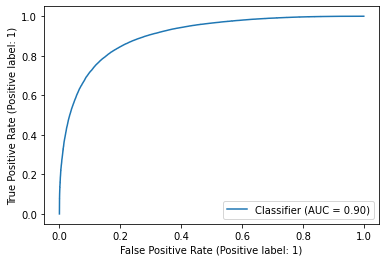

In [13]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay

#wheights_data = [2,1] #double the wheight on trues bc verhältnis ist 1:2
X = triplets

from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
print("transformed")


clf = HistGradientBoostingClassifier(random_state=0)
clf.fit(X, y)#, sample_weight =wheights_data)

y_pred = clf.predict_proba(triplets)[:,1]
RocCurveDisplay.from_predictions(y, y_pred) #just for training to look how good it really is use test/train split
plt.show()

In [14]:
y_pred[0]

0.6249799609954069

In [8]:
class Net(nn.Module):
    def __init__(self, in_Dim):
        super(Net, self).__init__()
        
        self.lin0 = nn.Linear(in_features=in_Dim, out_features=1024)
        self.lin1 = nn.Linear(in_features=1024, out_features=512)
        self.lin2 = nn.Linear(in_features=512, out_features=1)
        #self.lin3 = nn.Linear(in_features=256, out_features=64)
        #self.lin4 = nn.Linear(in_features=64, out_features=1)
        
        self.BN0 = nn.BatchNorm1d(1024)
        self.BN1 = nn.BatchNorm1d(512)
        #self.BN2 = nn.BatchNorm1d(256)
        #self.BN3 = nn.BatchNorm1d(64)
        self.act = nn.ReLU(inplace=True)
        
        self.DO = nn.Dropout(p=0.1)
        
    def forward(self, x):
        
        x = self.act(self.BN0(self.lin0(x)))
        x = self.DO(x)
        x = self.act(self.BN1(self.lin1(x)))
        return torch.sigmoid(self.lin2(x))
        #x = self.act(self.BN2(self.lin2(x)))
        #x = self.act(self.BN3(self.lin3(x)))
        #return torch.sigmoid(self.lin4(x))


In [9]:
epochs = 4
batch_size = 32
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
model = Net(triplets.shape[1]).to(device) #labels.shape[1] ).to(device)
print(model)

Net(
  (lin0): Linear(in_features=6144, out_features=1024, bias=True)
  (lin1): Linear(in_features=1024, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=1, bias=True)
  (BN0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act): ReLU(inplace=True)
  (DO): Dropout(p=0.1, inplace=False)
)


In [11]:
opt = optim.Adam(model.parameters(), lr=lr)
loss = nn.BCELoss()

In [12]:
train_data = triplets[:-2000]
val_data = triplets[-2000:]
train_labels = y[:-2000]
val_labels = y[-2000:]
print(len(train_data))

train_data = train_data.astype(dtype=np.float32)
val_data = val_data.astype(dtype=np.float32)
train_labels = train_labels.astype(dtype=np.float32)
val_labels =  val_labels.astype(dtype=np.float32)
print(train_data.dtype)
print(val_data.dtype)

117030
float32
float32


In [13]:
triplets2 = triplets
triplets2[:-2000] = train_data
triplets2[-2000:] = val_data
#X = X.astype(dtype=np.float32)
y =  y.astype(dtype=np.float32)

In [14]:
#X.dtype

In [15]:
def fit(model, inpX, inp_labels):
    inpX = inpX#.to(device)
    inp_labels = inp_labels#.to(device)
    model.train
    train_loss = []
    correct = 0
    model.to(device)
    for i in range(0, len(inp_labels)-batch_size, batch_size):
        if i % 10000 == 0:
            print(f"i: {i/10000}")   
        
        running_loss = 0.0
        X = inpX[i:(i+batch_size)].to(device)
        labels = inp_labels[i:i+batch_size].to(device)
        #print(X.device)

        
        opt.zero_grad()

        inp = model(X)#.detach().cpu()
        inp = inp.view(inp.shape[0])
        
        correct += (torch.round(inp) == labels).float().sum()

        
        output = loss(inp, labels)
        output.retain_grad()
        output.backward()
        running_loss += output.item()
        

        opt.step()

        train_loss.append(running_loss)
    accuracy = correct/len(inp_labels)
    return train_loss, accuracy

In [16]:
def validate(model, X, labels):
    X = X.to(device)
    labels = labels.to(device)
    model.eval()
    running_loss = 0.0
    correct = 0  
    
    with torch.no_grad():
        #for i in range(len(labels)):
        #print(X.device)
        
        opt.zero_grad()

        inp = model(X)        
        inp = inp.view(inp.shape[0])
        
        correct += (torch.round(inp) == labels).float().sum()
        
        output = loss(inp, labels)



        running_loss += output.item()
            
    val_loss = running_loss
    accuracy = correct/len(labels)
    return val_loss, accuracy

In [17]:
train_loss = []
val_loss = []
train_accuracies = []
val_accuracies = []
torch.backends.cudnn.benchmark = True #choose best kernel for computation

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")

    #train_epoch_loss, train_accuracy = fit(model, torch.from_numpy(train_data), torch.from_numpy(train_labels))
    train_epoch_loss, train_accuracy = fit(model, torch.from_numpy(triplets), torch.from_numpy(y))
    val_epoch_loss, val_accuracy = validate(model, torch.from_numpy(val_data), torch.from_numpy(val_labels))
    print(f"Train Loss: {np.mean(np.asarray(train_epoch_loss))}, Train Accuracy: {train_accuracy}")
    print(f"Val Loss: {np.mean(np.asarray(val_epoch_loss))}, Validation Accuracy: {val_accuracy}")
    train_loss.append(np.mean(np.asarray(train_epoch_loss)))
    val_loss.append(np.mean(np.asarray(val_epoch_loss)))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracies}")
print(f"Val Loss: {val_loss}, Validation Accuracy: {val_accuracies}")

Epoch 1 of 4
i: 0.0
i: 2.0
i: 4.0
i: 6.0
i: 8.0
i: 10.0
Train Loss: 0.47506759532294823, Train Accuracy: 0.7717718482017517
Val Loss: 0.25736096501350403, Validation Accuracy: 0.9300000667572021
Epoch 2 of 4
i: 0.0
i: 2.0
i: 4.0
i: 6.0
i: 8.0
i: 10.0
Train Loss: 0.4055181301991989, Train Accuracy: 0.8137444257736206
Val Loss: 0.19299061596393585, Validation Accuracy: 0.9455000162124634
Epoch 3 of 4
i: 0.0
i: 2.0
i: 4.0
i: 6.0
i: 8.0
i: 10.0
Train Loss: 0.31025101215500733, Train Accuracy: 0.8653953075408936
Val Loss: 0.1169498935341835, Validation Accuracy: 0.9695000648498535
Epoch 4 of 4
i: 0.0
i: 2.0
i: 4.0
i: 6.0
i: 8.0
i: 10.0
Train Loss: 0.22699531389094346, Train Accuracy: 0.9066286087036133
Val Loss: 0.07637442648410797, Validation Accuracy: 0.9820000529289246
Train Loss: [0.47506759532294823, 0.4055181301991989, 0.31025101215500733, 0.22699531389094346], Train Accuracy: [tensor(0.7718, device='cuda:0'), tensor(0.8137, device='cuda:0'), tensor(0.8654, device='cuda:0'), tensor(0.

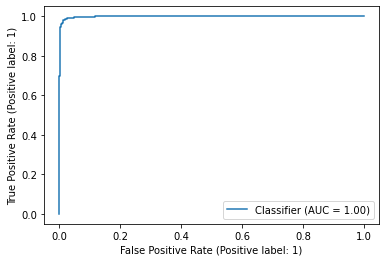

In [18]:
from sklearn.metrics import RocCurveDisplay
y_pred = model(torch.from_numpy(val_data).to(device)).detach().cpu().numpy()
RocCurveDisplay.from_predictions(val_labels, y_pred) #just for training to look how good it really is use test/train split
#y_pred = model(torch.from_numpy(triplets).to(device)).detach().cpu().numpy()
#RocCurveDisplay.from_predictions(y, y_pred) #just for training to look how good it really is use test/train split

plt.show()

In [22]:
y_pred[0]

array([0.99979645], dtype=float32)

Predictions
---

In [19]:
tripletsDF = pd.read_csv(r"C:\Users\erics\Documents\Programme\IntroML\Task3\task3_be9ai3nsdj\test_triplets.txt", delim_whitespace=True, header=None, names=["A", "B", "C"])
#i = 0
tripletsTest = []

for row in tripletsDF.iterrows():
    #print(row[1]['A'])
    arr = []
    arr.append(indices[row[1]['A']])
    arr.append(indices[row[1]['B']])
    arr.append(indices[row[1]['C']])
    
    triplet = np.concatenate((arr[0], arr[1], arr[2]), axis=-1) #arr[0].cpu(), arr[1].cpu(), arr[2].cpu()), axis=-1)
    tripletsTest.append(triplet)
    
tripletsTest = np.asarray(tripletsTest, dtype=np.float32)

In [20]:
tripletsTest.shape

(59544, 6144)

In [ ]:
yTest_pred = np.round_(clf.predict_proba(tripletsTest)[:,1])

In [21]:
model.cpu()
yTest_pred = np.round_(model(torch.from_numpy(tripletsTest)).detach().cpu().numpy())

In [22]:
np.savetxt("abgabeNewFeat.txt", yTest_pred, fmt='%d')

We tried several different approches to preprocess the data. The best one was to use a Resnet50 Model finetuned on the food part of the inception dataset. Unfortunately this net is only available on Keras. We took the net without the linear layers and classified all images with it. This gave us our features wich we concatinated according to the triplets. Using the knowledge that swapping the last two images we doubled our training set and had the same number of GT 0 as GT 1. This trainingdata is the fed into a small network of 3 linear layers with one dropout layer with p=0.1. The net was trained for 4 epochs over the full dataset in order not to overfit on the given data. With this trained model the test data was predicted.